# Mount Drive

In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Define Constants

In [0]:
sentences_per_doc = 40
words_per_sentence = 30
word_embeddings_size = 50
rows_to_read = 300000

# Load Data

In [0]:
import pandas as pd
import numpy as np

In [0]:
train_df = pd.read_csv("/content/drive/My Drive/nlp/data/training_labeled_cnn_data_full.csv", nrows=rows_to_read, index_col="article").drop(["Unnamed: 0"], axis=1)

In [0]:
test_df = pd.read_csv("/content/drive/My Drive/nlp/data/test_labeled_cnn_data_full.csv", index_col="article").drop(["Unnamed: 0"], axis=1)

In [0]:
def prepare_data(data_df):
  # seperate docs and labels
  data_df.labels.value_counts()
  data_df['labels'].replace(to_replace=1, value=0, inplace =True)
  data_df['labels'].replace(to_replace=2, value=1, inplace =True)
  data_df.labels.value_counts()
  
  # extract docs and labels
  docs = []
  labels = []
  for a, b in data_df.groupby('article'):
    docs.append(b['sentence'].tolist())
    labels.append(b['labels'].tolist())
    
    
    
  # extract lablers  
  import numpy as np
  y = np.full((len(labels), sentences_per_doc), 0)
  for curr_doc_labels, doc_labels in enumerate(labels):
    for curr_sentence_label, sentence_label in enumerate(doc_labels):
      if curr_sentence_label < sentences_per_doc:
        y[curr_doc_labels][curr_sentence_label] = labels[curr_doc_labels][curr_sentence_label]
        
        
  # Tokenzie 
  from nltk.tokenize import word_tokenize
  from nltk.tokenize import sent_tokenize
  import nltk
  nltk.download('punkt')
  
  docs_tokenized = []
  for doc in docs:
    doc_tokenized = []
    for sentence in doc:
      doc_tokenized.append(word_tokenize(sentence))
    docs_tokenized.append(doc_tokenized)
    
  flatten_docs_tokenized = [sentence for doc in docs_tokenized for sentence in doc]
  
  # Create Embeddings Dictionary
  from gensim.models import Word2Vec
  words_embeddings_model = Word2Vec(flatten_docs_tokenized, size=word_embeddings_size, window = 5, min_count=5)
  words_embeddings = words_embeddings_model.wv.vectors
  indexed_words = words_embeddings_model.wv.index2word
  word2embedding = dict(zip(indexed_words, words_embeddings))
  
  
  # Docs to Embeddings
  x = np.full((len(docs_tokenized), sentences_per_doc, words_per_sentence, word_embeddings_size), 0, dtype='float16')

  for curr_doc, doc in enumerate(docs_tokenized):
    for curr_sentence, sentence in enumerate(doc):
      if curr_sentence < sentences_per_doc:
        for curr_word, word in enumerate(sentence):
          if curr_word < words_per_sentence:
            embedding = word2embedding.get(word, np.ones(word_embeddings_size))
            x[curr_doc, curr_sentence, curr_word] = embedding
            
            
  # return x and y
  return x, y
  

In [70]:
x_train,y_train = prepare_data(train_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
print('x shape:', x_train.shape)
print('y shape:', y_train.shape)

x shape: (9942, 40, 30, 50)
y shape: (9942, 40)


In [72]:
x_test,y_test = prepare_data(test_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [73]:
print('x shape:', x_test.shape)
print('y shape:', y_test.shape)

x shape: (1093, 40, 30, 50)
y shape: (1093, 40)


# Imports

In [0]:
import keras.backend as K
import keras
import numpy as np
import tensorflow as tf
from keras.layers import Bidirectional, Input, LSTM
from keras.layers import Dense, Lambda
from keras.models import Model
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from keras.layers import Dense
from keras.layers import Layer

### Define model constants

In [0]:
# Sizes
model_output_size = sentences_per_doc
lstm_hidden_size = 200
densor1_output_size = 400
densor2_output_size = 400

In [0]:
# # Data
# num_of_training_examples = 2000
# x_train = np.random.rand(num_of_training_examples, sentences_per_doc, words_per_sentence, word_embeddings_size)
# y_train = np.random.randint(2, size=(num_of_training_examples, sentences_per_doc))
# print(x_train.shape)
# print(y_train.shape)

### Initialize LSTM + Attention per Sentence

In [0]:
# Initialize arrays
bi_lstms = []
densors_1 = []
densors_2 = []

for i in range(sentences_per_doc):
    bi_lstms.append(Bidirectional(LSTM(units=lstm_hidden_size, input_shape=(words_per_sentence, word_embeddings_size),
                                       return_sequences=True, name='bidirectional_' + str(i))))
    densors_1.append(Dense(densor1_output_size, activation="tanh", name='senteence_dense_tanh' + str(i)))
    densors_2.append(Dense(1, activation="softmax", name='senteence_dense_softmax' + str(i)))


In [0]:
def invoke_sentence(sentence_matrix, index):
    if index == 0:
        print(type(sentence_matrix))
        print(tf.shape(sentence_matrix))

    word_lstm = bi_lstms[index](sentence_matrix)
    attention_middle = densors_1[index](word_lstm)
    word_weights = densors_2[index](attention_middle)

    def mult(ip):
        a = ip[0]
        b = ip[1]
        return K.sum(a * b, axis=1)

    sentence_embedding = Lambda(mult)([word_weights, word_lstm])

    if index == 0:
        print(f'word_lstm shape is {word_lstm.shape}')
        print(f'attention_middle shape is {attention_middle.shape}')
        print(f'word_weights shape is {word_weights.shape}')
        print(f'sentence_embedding shape is {sentence_embedding.shape}')

    return sentence_embedding


### Define Custom Layer

In [0]:
class MyLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W_p = self.add_weight(name='W_p',
                                   shape=(400,),
                                   initializer='uniform',
                                   trainable=True)
        self.W_c = self.add_weight(name='W_c',
                                   shape=(400,),
                                   initializer='uniform',
                                   trainable=True)

        self.W_s = self.add_weight(name='W_s',
                                   shape=(400,),
                                   initializer='uniform',
                                   trainable=True)

        self.W_r = self.add_weight(name='W_r',
                                   shape=(400,),
                                   initializer='uniform',
                                   trainable=True)
        self.b = self.add_weight(name='b',
                                   shape=(400,),
                                   initializer='uniform',
                                   trainable=True)
        
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        def compute_sentence_features(d, sentences_embeddings_stacked, p_j, j, sentences_probs):
            print("sentences_embeddings_stacked", sentences_embeddings_stacked)
            s = sentences_embeddings_stacked[:, j]
            print("s", s)

            c = s * self.W_c
            m = s * self.W_s * d  # missing transpose

            o = 0
            if j == 0:
                o = sentences_embeddings_stacked[:, 0] * 0.5
            else:
                for i in range(0, j):
#                     print("i", i)
                    o += sentences_embeddings_stacked[:, i] * sentences_probs[i]
#                     print("o", o)

            n = s * self.W_r * K.tanh(o)  # missing transpose
            p = self.W_p * p_j
            return c, m, n, p, o

        def compute_sentence_prob(features):
            c, m, n, p = features
            sentece_prob = K.sigmoid(c + m - n + p + self.b)
            print("sentece_prob", sentece_prob)
            return sentece_prob

        document_embedding, sentences_embeddings_stacked, doc_lstm = x
        print(document_embedding, sentences_embeddings_stacked, doc_lstm)

        O = []
        sentences_probs = []
        for j in range(0, self.output_dim):
            c, m, n, p, o = compute_sentence_features(document_embedding, sentences_embeddings_stacked, doc_lstm[:, j], j, sentences_probs)
            if(j==0):
              print("j", j)
              print("c,m,n,p,o", c, m, n, p, o)
            sentences_probs.append(compute_sentence_prob((c, m, n, p)))
            O.append(o)

        print("sentences_probs", len(sentences_probs), sentences_probs)
        sentences_probs_stacked = tf.stack(sentences_probs, axis=1)
        print("sentences_probs_stacked", sentences_probs_stacked)

        output = Dense(self.output_dim, input_shape=(400,))(K.sum(sentences_probs_stacked, axis=1))

        output = K.softmax(output)  # missing bias
        print("output", output)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0][0], self.output_dim


# Define Custom Loss Function

In [0]:
# Define custom loss
def custom_loss(y_true, y_pred):
    def loss(y_true, y_pred):
        print(y_pred)
        print(y_true)

        return K.square(y_pred - y_true)

    # Return a function
    return loss(y_true, y_pred)
  
def simple_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

### Define Model

In [0]:
def model(words_per_sentence, sentences_per_doc, lstm_hidden_size, word_embeddings_size, model_output_size):
    """
    Arguments:
    words_per_sentence -- Tx -- length of the input sequence - max words per sentence
    sentences_per_doc --Ty -- length of the output sequence - number of sentences per document
    lstm_hidden_size -- hidden state size of the Bi-LSTM
    word_embeddings_size -- size of the word embeddings
    model_output_size -- size of each sentence label (1 or 0)

    Returns:
    model -- Keras model instance
    """
    sentences_embeddings = []

    X = Input(shape=(sentences_per_doc, words_per_sentence, word_embeddings_size), name='X')
    for t in range(sentences_per_doc):
        X_doc = Lambda(lambda x: x[:, t, :, :])(X)
        if t == 0:
            print("X_doc")
            print(type(X_doc))
            print(X_doc)
            print(X_doc.shape)

        sentence_embedding = invoke_sentence(X_doc, t)
        sentences_embeddings.append(sentence_embedding)
        if t == 0:
            print("sentence_embedding")
            print(type(sentence_embedding))
            print(sentence_embedding)
            print(sentence_embedding.shape)

    sentences_embeddings_stacked = Lambda(lambda x: tf.stack(x, axis=1))(sentences_embeddings)
    print("sentences_embeddings_stacked")
    print(type(sentences_embeddings_stacked))
    print(sentences_embeddings_stacked)
    print(sentences_embeddings_stacked.shape)

    doc_lstm = Bidirectional(LSTM(units=lstm_hidden_size, input_shape=(sentences_per_doc, lstm_hidden_size * 2),
                                  return_sequences=True, name='bidirectional_document'),
                             merge_mode='concat')(sentences_embeddings_stacked)
    print(f'doc_lstm shape is {doc_lstm.shape}')

    attention_middle = Dense(densor1_output_size, activation="tanh")(doc_lstm)
    sentences_weights = Dense(1, activation="softmax")(attention_middle)
    print(f'sentences_weights shape is {sentences_weights.shape}')

    def mult(ip):
        a = ip[0]
        b = ip[1]
        return K.sum(a * b, axis=1)

    document_embedding = Lambda(mult)([sentences_weights, doc_lstm])
    print(f'document_embedding shape is {document_embedding.shape}')

#     my_layer = MyLayer(output_dim=model_output_size)
#     outputs = my_layer([document_embedding, sentences_embeddings_stacked, doc_lstm])
    
    outputs = Dense(model_output_size, activation = 'softmax')(document_embedding)
    print(f'outputs shape is {outputs.shape}')

    model = Model(inputs=X, outputs=outputs)

    return model


In [82]:
model = model(words_per_sentence, sentences_per_doc, lstm_hidden_size, word_embeddings_size, model_output_size)

X_doc
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("lambda_127/strided_slice:0", shape=(?, 30, 50), dtype=float32)
(?, 30, 50)
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Shape_3:0", shape=(3,), dtype=int32)
word_lstm shape is (?, ?, 400)
attention_middle shape is (?, 30, 400)
word_weights shape is (?, 30, 1)
sentence_embedding shape is (?, 400)
sentence_embedding
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("lambda_128/Sum:0", shape=(?, 400), dtype=float32)
(?, 400)
sentences_embeddings_stacked
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("lambda_207/stack:0", shape=(?, 40, 400), dtype=float32)
(?, 40, 400)
doc_lstm shape is (?, ?, 400)
sentences_weights shape is (?, 40, 1)
document_embedding shape is (?, 400)
outputs shape is (?, 40)


In [0]:
# model.summary() # very long output

In [0]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [85]:
model.compile(loss=simple_loss, optimizer='adam', metrics=['mae', 'categorical_accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.000, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=15, validation_split=0.1, callbacks=[early_stopping])

Train on 8947 samples, validate on 995 samples
Epoch 1/15
8947/8947 [==============================] - 412s 46ms/step - loss: 69.4427 - mean_absolute_error: 0.1504 - categorical_accuracy: 0.0561 - val_loss: 64.9706 - val_mean_absolute_error: 0.1527 - val_categorical_accuracy: 0.0302
Epoch 2/15
8947/8947 [==============================] - 313s 35ms/step - loss: 62.1140 - mean_absolute_error: 0.1469 - categorical_accuracy: 0.0855 - val_loss: 64.2051 - val_mean_absolute_error: 0.1522 - val_categorical_accuracy: 0.0362
Epoch 3/15
8947/8947 [==============================] - 313s 35ms/step - loss: 61.2324 - mean_absolute_error: 0.1421 - categorical_accuracy: 0.1143 - val_loss: 64.2707 - val_mean_absolute_error: 0.1518 - val_categorical_accuracy: 0.0533
Epoch 4/15
8947/8947 [==============================] - 313s 35ms/step - loss: 60.5690 - mean_absolute_error: 0.1366 - categorical_accuracy: 0.1457 - val_loss: 64.4288 - val_mean_absolute_error: 0.1518 - val_categorical_accuracy: 0.0533
Epoch

In [0]:
# save wiehgts
model.save_weights("model_"+str(rows_to_read)+"_" + str(sentences_per_doc) + "_" + str(words_per_sentence) + "_" + str(word_embeddings_size) + "_dense_weights.h5")
# create df from history
hist_df = pd.DataFrame(history.history) 
# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Load Model

In [0]:
loaded_model = model(words_per_sentence, sentences_per_doc, lstm_hidden_size, word_embeddings_size, model_output_size)

In [0]:
loaded_model.load_weights("model_500000_weights.h5")

# Show Several Summaries Vs. True

In [0]:
predicted_probs = model.predict(x=x_test[0:10])

In [0]:
predicted_labels = (predicted_probs > 0.35).astype(int)

In [0]:
true_labels = y_test

In [96]:
predicted_labels[0:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [97]:
true_labels[0:10]

array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

# Visualize

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_categorical_accuracy', 'loss', 'mean_absolute_error', 'categorical_accuracy'])


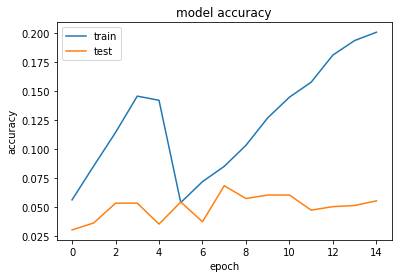

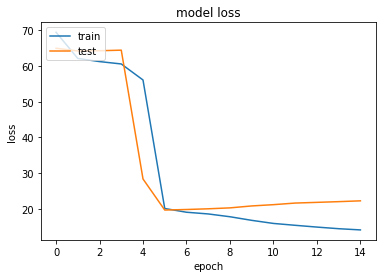

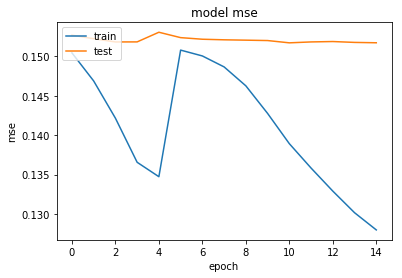

In [98]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Sources To Learn Attention

In [0]:
# https://github.com/gemaatienza/Deep-Learning-Coursera/blob/master/5.%20Sequence%20Models/Neural%20machine%20translation%20with%20attention%20-%20v4.ipynb
# https://colab.research.google.com/drive/1CwSdA1c8P7MXe4PcKh7HFCxzP2s_-AuJ#scrollTo=zXef38nBFxir
# https://github.com/gentaiscool/lstm-attention

# Seperate Functions Of Data Preperation

# Seperate Docs & Labels

In [0]:
docs = []
labels = []
for a, b in data_df.groupby('article'):
  docs.append(b['sentence'].tolist())
  labels.append(b['labels'].tolist())

# Extract Labels

In [0]:
import numpy as np
y = np.full((len(labels), sentences_per_doc), 0)
for curr_doc_labels, doc_labels in enumerate(labels):
  for curr_sentence_label, sentence_label in enumerate(doc_labels):
    if curr_sentence_label < sentences_per_doc:
      y[curr_doc_labels][curr_sentence_label] = labels[curr_doc_labels][curr_sentence_label]

# Tokenzie

In [0]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
docs_tokenized = []
for doc in docs:
  doc_tokenized = []
  for sentence in doc:
    doc_tokenized.append(word_tokenize(sentence))
  docs_tokenized.append(doc_tokenized)

In [0]:
flatten_docs_tokenized = [sentence for doc in docs_tokenized for sentence in doc]

# Create Embeddings Dictionary

In [0]:
from gensim.models import Word2Vec
words_embeddings_model = Word2Vec(flatten_docs_tokenized, size=word_embeddings_size, window = 5, min_count=5)
words_embeddings = words_embeddings_model.wv.vectors
indexed_words = words_embeddings_model.wv.index2word
word2embedding = dict(zip(indexed_words, words_embeddings))

# Docs to Embeddings

In [0]:
x = np.full((len(docs_tokenized), sentences_per_doc, words_per_sentence, word_embeddings_size), 0, dtype='float32')

for curr_doc, doc in enumerate(docs_tokenized):
  for curr_sentence, sentence in enumerate(doc):
    if curr_sentence < sentences_per_doc:
      for curr_word, word in enumerate(sentence):
        if curr_word < words_per_sentence:
          embedding = word2embedding.get(word, np.ones(word_embeddings_size))
          x[curr_doc, curr_sentence, curr_word] = embedding

In [0]:
print('x shape:', x.shape)
print('y shape:', y.shape)

# Save & Load Ready Data

In [0]:
# np.save('x_train', x_train)

In [0]:
# x_train = np.load('x_train.npy')